<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/numerical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import os
import shutil
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets, transforms
import shutil
import os
from google.colab import drive


# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/numerical_model.ipynb"
destination_path = "/content/drive/My Drive/numerical_model.ipynb"

  # Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")

!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    create_dataloaders as create_dataloaders,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,
    standardization as standardization,
    data_filter as data_filter,
    standardization as standardization,
    TransactionDataset as TransactionDataset

)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class TransactionDataset(Dataset):

    def __init__(self, X, y):
        # Ensure that all values are numeric and convert to numpy arrays of correct dtype
        self.X = X.reset_index(drop=True).values.astype('float32')  # Ensure float32 type
        self.y = y.reset_index(drop=True).values.astype('float32')  # Ensure float32 type

    def __len__(self):
        # Return the total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Fetch one sample by index
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return torch.tensor(x_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
    # Create the training dataset and dataloader
    train_dataset = TransactionDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Create the testing dataset and dataloader
    test_dataset = TransactionDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [46]:
class Numerical_Model(nn.Module):
    def __init__(self, in_features):
        super(Numerical_Model, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.3)  # Lower dropout
        self.leaky_relu = nn.LeakyReLU(0.01)  # Leaky ReLU instead of ReLU

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation for regression
        return x

def train(network, trainloader, testloader, epochs=100, eta=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)
    loss = torch.nn.MSELoss()
    val_loss = []

    for epoch in range(epochs):
        # Initialize the total loss for train and test data
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples

        # Train the network on training data
        for x, t in trainloader:
            network.train()
            optimizer.zero_grad()
            x, t = x.to(device), t.to(device)
            z = network(x)
            t = t.view(-1, 1)
            J = loss(z, t)
            J_train += J.item() * x.size(0)
            total_train_samples += x.size(0)
            J.backward()
            optimizer.step()

        # Compute the average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0
        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, t in testloader:
                x, t = x.to(device), t.to(device)
                z = network(x)
                t = t.view(-1, 1)
                J_test += loss(z, t).item() * t.size(0)
                total_test_samples += t.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples


        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # save predictions and targets after last epoch
    pred, target = [],[]
    with torch.no_grad():
      network.eval()
      for x, t in testloader:
        prediction = network(x.to(device))
        pred.extend(prediction.view(-1).detach().cpu().numpy())
        target.extend(t.view(-1).detach().cpu().numpy())


    return network, pred, target

Epoch [1/10] Train loss: 11.699885 Test loss: 1.543518
Epoch [2/10] Train loss: 2.848290 Test loss: 1.330470
Epoch [3/10] Train loss: 2.475845 Test loss: 1.285968
Epoch [4/10] Train loss: 2.193674 Test loss: 1.286063
Epoch [5/10] Train loss: 2.014526 Test loss: 1.199780
Epoch [6/10] Train loss: 1.822532 Test loss: 1.151389
Epoch [7/10] Train loss: 1.692895 Test loss: 1.184770
Epoch [8/10] Train loss: 1.568686 Test loss: 1.122213
Epoch [9/10] Train loss: 1.461851 Test loss: 1.097402
Epoch [10/10] Train loss: 1.390264 Test loss: 1.109205
3     1.020408
5     1.040816
15    1.081633
16    1.061224
22    1.040816
Name: transaction_year_semi, dtype: float64
Total test batches: 348
Total test samples: 11122
Test data shape : (11122, 1157)
Train data shape : (62845, 1157)
Std of y_test: 1.6380767854050475
Std of predictions: 1.2769735
R-squared: 0.587


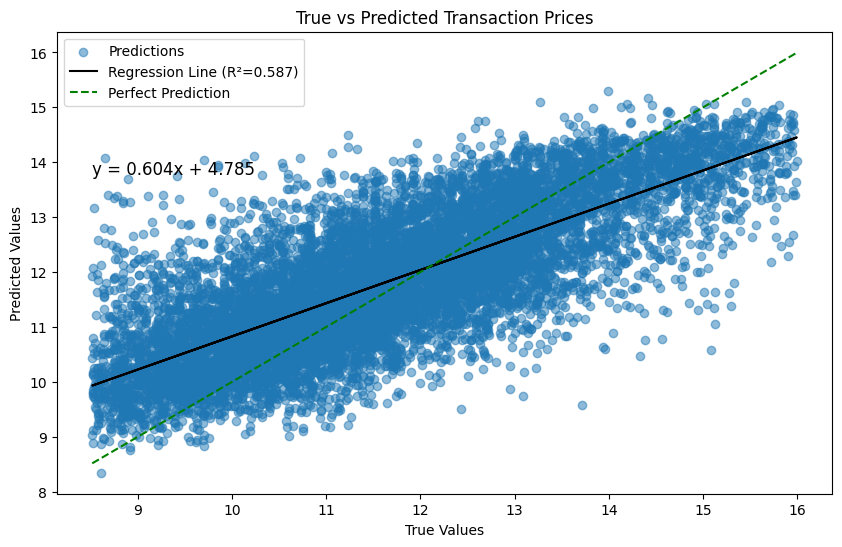

R-squared: 0.433


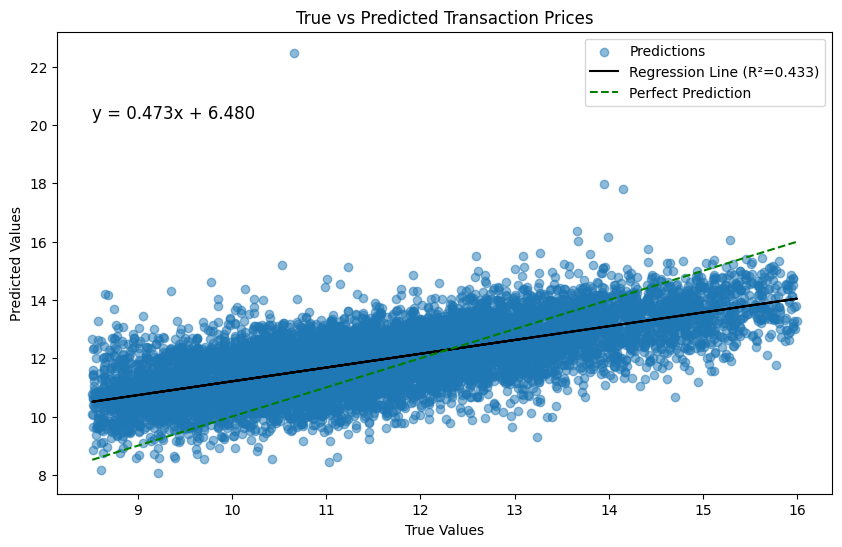

In [47]:
if __name__ == '__main__':
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house', 'transaction_year_semi']
  one_hot_vars = ['category', 'artist', 'medium', 'transaction_house']


  X_train, X_test, y_train, y_test = data_split(artwork_numeric_data,
                                                   selected_vars,
                                                   one_hot_vars, 2020)
  trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test)


  # Initialize the model with the correct number of input features
  model = Numerical_Model(in_features=X_train.shape[1])


  # Train the model
  NumericalModel, prediction_numerical_model, target = train(model, trainloader,
                                                           testloader,
                                                           epochs = 10)



  # sample checks

  print(X_test['transaction_year_semi'].head())
  print(f"Total test batches: {len(testloader)}")
  print(f"Total test samples: {len(y_test)}")
  print(f"Test data shape : {X_test.shape}")
  print(f"Train data shape : {X_train.shape}")
  print("Std of y_test:", np.std(y_test))
  print("Std of predictions:", np.std(prediction_numerical_model))



  # Train the model using the training data
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)



  fit_visualization(target, prediction_numerical_model)
  fit_visualization(target, y_pred)




